In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import os
import math
import cv2

from matplotlib import pyplot
import matplotlib.patches as patches

from skimage import measure
from skimage.transform import resize

import seaborn as sns
import pydicom as dcm

from sklearn import metrics
from sklearn.metrics import classification_report

In [3]:
import tensorflow as tf
import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence

from tensorflow.keras.layers import Layer, Concatenate, UpSampling2D, Conv2D, Reshape, BatchNormalization, Activation
from tensorflow.keras.models import Model

#For MobileNet
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

#For ResNet50
#from tensorflow.keras.applications.resnet import ResNet50

#For tunning of model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

In [4]:
cwd = os.getcwd()
cwd

'C:\\Users\\Admin\\Downloads'

In [5]:
import os
os.chdir(r"C:\Users\Admin\Downloads\rsna-pneumonia-detection-challenge") 
cwd = os.getcwd() 
data_dir = cwd

train_images = os.path.join(data_dir,'stage_2_train_images')

In [6]:
class image_metadata():
    """
    Arguments:
        setName = name of the dataset
        file = filename
    """
    
    def __init__(self, setName, file):
        self.setName = setName
        self.file = file
    
    def __repr__(self):
        #a special method used to represent a class's objects as a string
        return self.imagePath()
    
    def imagePath(self):
        return os.path.join(self.setName, self.file)

In [7]:
#function to load image metadata
def loadimagemetadata(dataSetName):
    """
    Arguments:
        dataSetName: path of the data set folder
    """
    
    imageMetadata = []
    for f in os.listdir(dataSetName):
        ext = os.path.splitext(f)[1]
        if ext == '.dcm':
            imageMetadata.append(image_metadata(dataSetName, f))
    return np.array(imageMetadata)

In [8]:
#function to load image and patientId
def loadImage(path):
    """
    Arguments:
        path: path of the image
    """
    
    img = dcm.dcmread(path)
    return img

#def getImgId(imgPath):
 #   """
  #  Arguments:
   #     imgPath: path of the image
    #"""
    
    #return str(imgPath).split(".dcm")[0].split("/")[2]

In [9]:
trainingSetImageMetadata = loadimagemetadata(train_images)
print('Shape of training set image metadata: ', trainingSetImageMetadata.shape)
print("Sample image path: ", trainingSetImageMetadata[0])

Shape of training set image metadata:  (26684,)
Sample image path:  C:\Users\Admin\Downloads\rsna-pneumonia-detection-challenge\stage_2_train_images\0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm


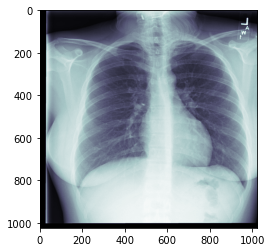

In [10]:
imgIndex = 20
imgPath = trainingSetImageMetadata[imgIndex]
imgPath = imgPath.imagePath()
imgData = loadImage(imgPath)

pyplot.imshow(imgData.pixel_array, cmap = pyplot.cm.bone)

In [11]:
#trainSetImageMetadata_df = pd.DataFrame(trainingSetImageMetadata, columns = ['Path'])

#imageIdpaths = pd.DataFrame(columns = ['patientId', 'imgPath'])
#imageIdpaths['patientId'] = trainSetImageMetadata_df['Path']
#imageIdpaths['imgPath'] = trainSetImageMetadata_df['Path']

#print("Shape of the concerned dataset: ", imageIdpaths.shape)
#print('The dataset looks as:\n')
#imageIdpaths.head()

In [12]:
detailclass_df = pd.read_csv('stage_2_detailed_class_info.csv')
trainlabels_df = pd.read_csv('stage_2_train_labels.csv')

In [13]:
print('The detailed class dataframe has {} rows and {} columns and looks like:'.format(detailclass_df.shape[0], detailclass_df.shape[1]))
detailclass_df.head()

The detailed class dataframe has 30227 rows and 2 columns and looks like:


patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [14]:
print('The training label dataframe has {} rows and {} columns and looks like:'.format(trainlabels_df.shape[0], trainlabels_df.shape[1]))
trainlabels_df.head()

The training label dataframe has 30227 rows and 6 columns and looks like:


patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [15]:
#sorting both the datasets based on patientId
trainlabels_df.sort_values('patientId', inplace = True)
detailclass_df.sort_values('patientId', inplace = True)

#concatenating the data
merge_data_df = pd.concat([trainlabels_df, detailclass_df['class']], axis = 1, sort = False)
print('The merged dataset has {} rows and {} columns and looks like:'.format(merge_data_df.shape[0], merge_data_df.shape[1]))
merge_data_df.head()

The merged dataset has 30227 rows and 7 columns and looks like:


patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
28989  000924cf-0f8d-42bd-9158-1af53881a557    NaN    NaN    NaN     NaN   
28990  000db696-cf54-4385-b10b-6b16fbb3f985  316.0  318.0  170.0   478.0   
28991  000db696-cf54-4385-b10b-6b16fbb3f985  660.0  375.0  146.0   402.0   
28992  000fe35a-2649-43d4-b027-e67796d412e0  570.0  282.0  269.0   409.0   

       Target                         class  
0           0  No Lung Opacity / Not Normal  
28989       0                        Normal  
28990       1                  Lung Opacity  
28991       1                  Lung Opacity  
28992       1                  Lung Opacity

In [16]:
#convert the dataset into two classes only:
merge_data_df['class'].replace('No Lung Opacity / Not Normal', 'Normal', inplace = True)
print('The merge dataset now looks like:')
merge_data_df.head()

The merge dataset now looks like:


patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
28989  000924cf-0f8d-42bd-9158-1af53881a557    NaN    NaN    NaN     NaN   
28990  000db696-cf54-4385-b10b-6b16fbb3f985  316.0  318.0  170.0   478.0   
28991  000db696-cf54-4385-b10b-6b16fbb3f985  660.0  375.0  146.0   402.0   
28992  000fe35a-2649-43d4-b027-e67796d412e0  570.0  282.0  269.0   409.0   

       Target         class  
0           0        Normal  
28989       0        Normal  
28990       1  Lung Opacity  
28991       1  Lung Opacity  
28992       1  Lung Opacity

In [17]:
train_mergedata = merge_data_df[0:15000]
validate_mergedata = merge_data_df[15000:25000]
test_mergedata = merge_data_df[25000:30227]

print('Shape of training data: ', train_mergedata.shape)
print('Shape of validation data: ', validate_mergedata.shape)
print('Shape of test data: ', test_mergedata.shape)

Shape of training data:  (15000, 7)
Shape of validation data:  (10000, 7)
Shape of test data:  (5227, 7)


In [18]:
#setting all NaN values to 0 in both the data sets
#x, y, width and hight values as zero(0) means no bounding box.
train_mergedata.fillna(0, inplace = True)
print('The training data now looks as: \n')
train_mergedata.head()

The training data now looks as: 



patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0   
28989  000924cf-0f8d-42bd-9158-1af53881a557    0.0    0.0    0.0     0.0   
28990  000db696-cf54-4385-b10b-6b16fbb3f985  316.0  318.0  170.0   478.0   
28991  000db696-cf54-4385-b10b-6b16fbb3f985  660.0  375.0  146.0   402.0   
28992  000fe35a-2649-43d4-b027-e67796d412e0  570.0  282.0  269.0   409.0   

       Target         class  
0           0        Normal  
28989       0        Normal  
28990       1  Lung Opacity  
28991       1  Lung Opacity  
28992       1  Lung Opacity

In [19]:
validate_mergedata.fillna(0, inplace = True)
print('\nThe validation data now looks as:\n')
validate_mergedata.head()


The validation data now looks as:



patientId      x      y  width  height  \
13841  8a546535-613f-49b1-897c-a0933c53cb84   97.0  157.0  228.0   583.0   
13842  8a546535-613f-49b1-897c-a0933c53cb84  446.0  175.0  247.0   644.0   
13843  8a56a448-1214-4d0d-a6b2-d5e285d8742f    0.0    0.0    0.0     0.0   
13844  8a57180c-4321-475a-8448-8db41045c604    0.0    0.0    0.0     0.0   
13845  8a58d9e2-9cf1-405b-8e7e-102117a8200d    0.0    0.0    0.0     0.0   

       Target         class  
13841       1  Lung Opacity  
13842       1  Lung Opacity  
13843       0        Normal  
13844       0        Normal  
13845       0        Normal

In [20]:
test_mergedata.fillna(0, inplace = True)
print('The test data now looks as:')
test_mergedata.head()

The test data now looks as:


patientId      x      y  width  height  \
23762  d5d0be71-4579-411a-9218-0f45a80df505    0.0    0.0    0.0     0.0   
23763  d5d46405-ff85-46fa-9c3b-2c21ad366f76  709.0  534.0   96.0    65.0   
23764  d5d6f7e3-5143-4955-901e-cad92024fee0    0.0    0.0    0.0     0.0   
23765  d5d7c95e-0682-4b93-bf0b-5dff2fa91a92  215.0  221.0  188.0   253.0   
23766  d5d7c95e-0682-4b93-bf0b-5dff2fa91a92  594.0  256.0  230.0   176.0   

       Target         class  
23762       0        Normal  
23763       1  Lung Opacity  
23764       0        Normal  
23765       1  Lung Opacity  
23766       1  Lung Opacity

In [21]:
df = pd.read_csv('stage_2_train_labels.csv')

In [22]:
df.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [23]:
l = []
pid = []
for i in df["patientId"]:
    pid.append(i)
    l.append(i+".dcm")

In [24]:
imageIdpaths = pd.DataFrame({'patientId':pid,'imgPath':l})

imageIdpaths 

patientId  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd   
2      00322d4d-1c29-4943-afc9-b6754be640eb   
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5   
4      00436515-870c-4b36-a041-de91049b9ab4   
...                                     ...   
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8   
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba   
30224  c1f6b555-2eb1-4231-98f6-50a963976431   
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a   

                                        imgPath  
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm  
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm  
2      00322d4d-1c29-4943-afc9-b6754be640eb.dcm  
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm  
4      00436515-870c-4b36-a041-de91049b9ab4.dcm  
...                                         ...  
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8.dcm  
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba.dcm  
30224  c1f6b555-2eb1-4231-98f6-50a963976431.dcm  
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a.dcm  
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a.dcm  

[30227 rows x 2 columns]

In [25]:
print("Number of unique patients in training dataset: ", train_mergedata["patientId"].nunique())
print("Number of unique patients in validation dataset: ", validate_mergedata["patientId"].nunique())
print("Number of unique patients in test dataset: ", test_mergedata["patientId"].nunique())

Number of unique patients in training dataset:  13163
Number of unique patients in validation dataset:  8601
Number of unique patients in test dataset:  4920


In [26]:
imageIdpaths.sort_values('patientId', inplace = True)

train_imageIdpaths = imageIdpaths[0:15000]
validate_imageIdpaths = imageIdpaths[15000:25000]
test_imageIdpaths = imageIdpaths[25000:30227]

print('Shape of training dataframe having patientId and image paths: ', train_imageIdpaths.shape)
print('Shape of validation dataframe having patientId and image paths: ', validate_imageIdpaths.shape)
print('Shape of test dataframe having patientId and image paths: ', test_imageIdpaths.shape)

Shape of training dataframe having patientId and image paths:  (15000, 2)
Shape of validation dataframe having patientId and image paths:  (10000, 2)
Shape of test dataframe having patientId and image paths:  (5227, 2)


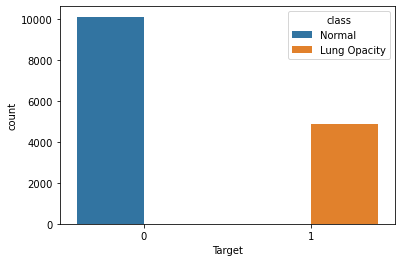

In [27]:
sns.countplot(x = 'Target', hue = 'class', data = train_mergedata)

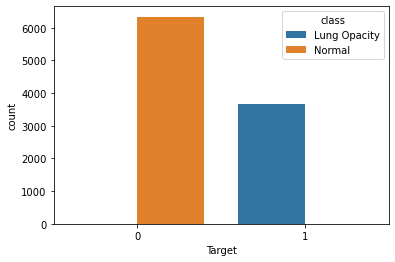

In [28]:
sns.countplot(x = 'Target', hue = 'class', data = validate_mergedata)

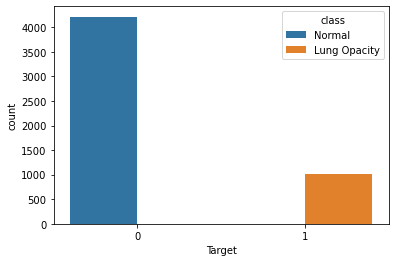

In [29]:
sns.countplot(x = 'Target', hue = 'class', data = test_mergedata)

In [30]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    """
    Arguments:
        y_true -- ground truth mask 
        y_pred -- predicted mask
    """
    
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# mean iou as a metric
def mean_iou(y_true, y_pred):
    """
    Arguments:
        y_true -- ground truth mask
        y_pred -- predicted mask
    """
    
    y_pred = tf.round(y_pred)    
    intersect = tf.reduce_sum(y_true * y_pred, axis = [1]) 
    union = tf.reduce_sum(y_true, axis = [1]) + tf.reduce_sum(y_pred, axis = [1])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

In [31]:
def iouFromCoords(boxA, boxB) :
    """
    Arguments:
        boxA -- ground truth mask
        boxB -- predicted mask
    """
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    intersectionArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if intersectionArea == 0:
        return 0
    
    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union
    iou = intersectionArea / float(boxAArea + boxBArea - intersectionArea)

    # return the intersection over union value
    return iou

In [32]:
def showMaskedImage(_imageSet, _maskSet, _index) :
    """
    Arguments:
        _imageSet -- set of images 
        _maskSet -- set of masks
        _index -- index of a set/collection
    """
    
    maskImage = _imageSet[_index]

    maskImage[:,:,0] = _maskSet[_index] * _imageSet[_index][:,:,0]
    maskImage[:,:,1] = _maskSet[_index] * _imageSet[_index][:,:,1]
    maskImage[:,:,2] = _maskSet[_index] * _imageSet[_index][:,:,2]

    pyplot.imshow(maskImage[:,:,0], cmap=pyplot.cm.bone)

In [33]:
image_size = 224
img_width = 1024
img_height = 1024

train_batch_size = 10
test_batch_size = 10

In [34]:
#Generator class to get data batch for training the model. It extends the Sequence class
class UNetTrainGenerator(Sequence):
    """
    Arguments:
        _imgaeIdpaths: dataframe having patientIds and image paths to load the image
        _mergedata: dataframe having patientId, bounding box coordinates, target and class
        idx: index of the batch
    """
    
    def __init__(self, _imageIdPaths, _mergedata):
        self.pids = _mergedata['patientId'].to_numpy()
        self.imgIdPaths = _imageIdPaths
        self.coords = _mergedata[["x", "y", "width", "height"]].to_numpy()
        self.coords = self.coords * image_size / img_width
        
    def __len__(self):
        return math.ceil(len(self.coords) / train_batch_size)
    
    def __getitem__(self, idx):
        batch_coords = self.coords[idx * train_batch_size:(idx + 1) * train_batch_size] #image coords
        batch_pids = self.pids[idx * train_batch_size:(idx + 1) * train_batch_size] #image pids
        
        batch_images = np.zeros((len(batch_pids), image_size, image_size, 3), dtype = np.float32)
        batch_masks = np.zeros((len(batch_pids), image_size, image_size))
        
        for _indx, _pid in enumerate(batch_pids):
            _path = self.imgIdPaths[self.imgIdPaths["patientId"] == _pid]['imgPath'].array[0]
            _imgData = loadImage(str(_path))
            img = _imgData.pixel_array
            
            resized_image = cv2.resize(img, (image_size, image_size), interpolation = cv2.INTER_AREA)
            
            #preprocess image
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_image[:,:], dtype = np.float32))
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_image[:,:], dtype = np.float32))
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_image[:,:], dtype = np.float32))
            
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2]) 
            height = int(batch_coords[_indx, 3])
            
            batch_masks[_indx][y:y+height, x:x+height] = 1
        
        return batch_images, batch_masks

In [35]:
#Generator to Predict the model
class UNetTestGenerator(Sequence):
    """        
    Arguments:
        _imageIdPaths: dataframe having patientId and image paths to load image
        _mergedata: dataframe having patientId, bounding box coordinates, target and class      
        idx -- index of a batch
    """
    
    def __init__(self, _imageIdPaths, _mergedata):       
        self.pids = _mergedata["patientId"].to_numpy()
        self.imgIdPaths = _imageIdPaths
        self.coords = _mergedata[["x", "y", "width", "height", "Target"]].to_numpy()
        self.classes = _mergedata["class"]
        # Resize Bounding box
        self.coordsOrig = self.coords
        self.coords = self.coords * image_size / img_width           

    def __len__(self):
        # Returns total number of batches
        return math.ceil(len(self.coords) / test_batch_size)
    

    def __getitem__(self, idx):
        batch_coords = self.coords[idx * test_batch_size:(idx + 1) * test_batch_size]
        batch_coordsOrig = self.coordsOrig[idx * test_batch_size:(idx + 1) * test_batch_size]
        batch_pids = self.pids[idx * test_batch_size:(idx + 1) * test_batch_size]    
        batch_classes = self.classes[idx * test_batch_size:(idx + 1) * test_batch_size]           
        
        batch_images = np.zeros((len(batch_pids), image_size, image_size, 3), dtype=np.float32)
        batch_masks = np.zeros((len(batch_pids), image_size, image_size))
        for _indx, _pid in enumerate(batch_pids):
            _path = self.imgIdPaths[self.imgIdPaths["patientId"] == _pid]["imgPath"].array[0]
            _imgData = loadImage(str(_path))
            img = _imgData.pixel_array 
            
            # Resize image
            resized_img = cv2.resize(img, (image_size, image_size), interpolation=cv2.INTER_AREA)
            # preprocess image for the batch
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32))
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32))
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32))  
            
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2])
            height = int(batch_coords[_indx, 3])
            target = int(batch_coords[_indx, 4])
            
            batch_coords[_indx, 0] = x
            batch_coords[_indx, 1] = y 
            batch_coords[_indx, 2] = width 
            batch_coords[_indx, 3] = height    
            batch_coords[_indx, 4] = target 
            
            batch_masks[_indx][y:y+height, x:x+width] = 1

        # Returns images, ground truth masks, patientIds, resized-coordinates, class targets and ground truth coordinates/lables.   
        return batch_images, batch_masks, batch_pids, batch_coords, batch_classes, batch_coordsOrig

In [36]:
#Function to create UNet architecture with MobileNet
def create_UNetModel(trainable=True):
    """        
    Arguments:
        trainable: Flag to make layers trainable. Default value is 'True'.
    """
    # Get all layers with 'imagenet' weights
    model = MobileNet(input_shape = (image_size, image_size, 3), include_top=False,
                      alpha = 1.0, weights="imagenet") 
    # Top layer is last layer of the model
    
    # Make all layers trainable
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    convLayer_112by112 = model.get_layer("conv_pw_1_relu").output
    convLayer_56by56 = model.get_layer("conv_pw_3_relu").output
    convLayer_28by28 = model.get_layer("conv_pw_5_relu").output
    convLayer_14by14 = model.get_layer("conv_pw_11_relu").output
    convLayer_7by7 = model.get_layer("conv_pw_13_relu").output
    # The last layer of mobilenet model is of dimensions (7x7x1024)
    # Steps to upsample from 7x7 to 14x14..upto 224x224 to form UNET
    x = Concatenate()([UpSampling2D()(convLayer_7by7), convLayer_14by14])
    x = Concatenate()([UpSampling2D()(x), convLayer_28by28])
    x = Concatenate()([UpSampling2D()(x), convLayer_56by56])
    x = Concatenate()([UpSampling2D()(x), convLayer_112by112])
    x = UpSampling2D(name="unet_last")(x) # upsample to 224x224

    # Add classification layer
    x = Conv2D(1, kernel_size=1, activation="sigmoid", name="masks")(x)
    x = Reshape((image_size, image_size))(x) 

    return Model(inputs=model.input, outputs=x)

In [37]:
def showConfusionMatrix(IOU_report) :
    """   
    Arguments:
        IOU_report: dataframe having target and prediction columns.
    """
    
    IOU_report.fillna(0, inplace=True)
    
    # Get Targets and Predictions
    y_IOU_test = IOU_report["Target"]
    y_IOU_predicted = IOU_report["predTarget"]
    print("Predictions in terms of IOU :\n")
    print("Confusion Matrix:\n", metrics.confusion_matrix(y_IOU_test, y_IOU_predicted))
    print("\nClassification Report:\n", metrics.classification_report(y_IOU_test, y_IOU_predicted))

In [38]:
def predictBatches(_test_mergedata, _test_imageIdpaths, _UNetModel) :
    """        
    Arguments:
        _test_mergedata: test set dataframe having patientId, bounding box coordinates, target and class
        _test_imageIdpaths: test set dataframe having patientId and image paths to load image        
        _UNetModel: UNet model with trainined weights used for predicting test data
    """
    
    print('Number of Test Samples:', _test_mergedata["patientId"].nunique())
    
    # create test generator instance
    testUNetDataGen = UNetTestGenerator(_test_imageIdpaths, _test_mergedata)
    
    # create submission dafa frame with column names
    submissionDF = pd.DataFrame(columns=['patientId', 'x', 'y', 'width', 'height', 'Target', 'class', 'x_pred', 'y_pred', 'width_pred', 
                                         'height_pred', 'predTarget', 'iou', 'class_pred'])
    dfIndex = 0
    iouThreshold = 0.3 # IoU above 30%

    # loop through testset
    # for batches from testUNetDataGen
    print("Predicting Batches ", end='')
    for batchImages, gtBatchMasks, batchPids, batchCoords, batchClasses, batchCoordsOrig in testUNetDataGen:
        
        # predict batch of images
        batchPreds = _UNetModel.predict(batchImages)

        prevPid = ""
        # loop through batch
        for pred, gtMask, pid, coords, gtClass, coordsOrig in zip(batchPreds, gtBatchMasks, batchPids, batchCoords, batchClasses, batchCoordsOrig):   #for (224, 224)

            if prevPid != pid :
                prevPid = pid

                # resize predicted mask
                pred = resize(pred, (1024, 1024), mode='reflect')   #for (1024, 1024)
                # recompute coords for resized pred
                coords = coordsOrig   #for (1024, 1024)

                # threshold predicted mask
                strongPred = pred[:, :] > 0.5   

                # apply connected components
                strongPred = measure.label(strongPred)

                loopIndx = 0
                # collect all reagions for the prediction
                iouCoordsDF = pd.DataFrame(columns=['iou', 'x', 'y', 'width', 'height'])
                for region in measure.regionprops(strongPred) :
                    # retrieve x, y, height and width
                    y, x, y2, x2 = region.bbox
                    height = y2 - y
                    width = x2 - x
                    # Get IOUs
                    coordsXYs = np.array([coords[0], coords[1], coords[2]+coords[0], coords[3]+coords[1]])
                    regionXYs = np.array([x, y, x2, y2])
                    IOU = iouFromCoords(coordsXYs, regionXYs)
                    iouCoordsRow = [IOU, x, y, width, height]
                    iouCoordsDF.loc[loopIndx] = iouCoordsRow
                    loopIndx = loopIndx + 1

                GTDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4], gtClass] # ground truth data 
                prevGTDFRow = []
                # Get top 2 predictions based on IOU 
                iouCoordsDF.sort_values("iou", ascending=False, inplace=True)
                predIOUCoordCount = 0
                # If predictions exist
                if len(iouCoordsDF) > 0 :
                    for predIOUCoordIdx in (0, len(iouCoordsDF)-1) :
                        if iouCoordsDF.loc[predIOUCoordIdx]["iou"] > iouThreshold :
                            # add row with ground truth and prediction values to data frame    
                            submissionDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4],
                                               gtClass, int(iouCoordsDF.loc[predIOUCoordIdx]["x"]), int(iouCoordsDF.loc[predIOUCoordIdx]["y"]), 
                                               int(iouCoordsDF.loc[predIOUCoordIdx]["width"]), int(iouCoordsDF.loc[predIOUCoordIdx]["height"]), 
                                               1, iouCoordsDF.loc[predIOUCoordIdx]["iou"], "Lung Opacity"]
                            if predIOUCoordCount < 2 :
                                if GTDFRow != prevGTDFRow : 
                                    submissionDF.loc[dfIndex] = submissionDFRow
                                    dfIndex = dfIndex + 1 
                                    predIOUCoordCount = predIOUCoordCount + 1
                                    prevGTDFRow = GTDFRow
                            else :
                                break;
                        else : # Normal if IOU below threshold
                            # add row with ground truth and prediction values to data frame
                            if GTDFRow != prevGTDFRow :  
                                submissionDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4], 
                                                   gtClass, 0, 0, 0, 0, 0, iouCoordsDF.loc[predIOUCoordIdx]["iou"], "Normal"]
                                submissionDF.loc[dfIndex] = submissionDFRow
                                dfIndex = dfIndex + 1  
                                prevGTDFRow = GTDFRow
                                break;
                else : # else of If predictions exist. Normal if no predictions
                    # add row with ground truth and prediction values to data frame
                    submissionDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4], 
                                       gtClass, 0, 0, 0, 0, 0, 'NA', "Normal"]
                    submissionDF.loc[dfIndex] = submissionDFRow
                    dfIndex = dfIndex + 1      

    # save dictionary as csv file
    submissionDF.to_csv('submission.csv', index=False)
    print("Prediction Complete!")
    
    test_y = submissionDF["Target"]
    predicted_y = submissionDF["predTarget"]
    
    return test_y.apply(int), predicted_y.apply(int)

In [39]:
def visualizePredictions(_predReportDF, _topNum) :
    """        
    Arguments:
        _predReportDF: dataframe having patientId, IoUs, target and prediction coordinate columns.
        _topNum -- number indicating the count of top predictions to be visualized.
    """
    # Sort on IOU to get higher IOUs on top
    _predReportDF.sort_values("iou", ascending=False, inplace=True)
    # Get patientIds
    topPids = _predReportDF["patientId"].head(_topNum)
    topPidsAry = np.array(topPids)
    # Get IOUs
    topIOUs = _predReportDF["iou"].head(_topNum)
    topIOUsAry = np.array(topIOUs)

    # To get ground truth images for top IOU scored pids
    imageCollc = np.zeros((_topNum, img_width, img_height), np.float32)

    # Get ground truth coordinates for top IOU scored rows and prepare masks
    gtCoordCollc = _predReportDF[["x", "y", "width", "height"]].to_numpy()
    # To get ground truth masks
    gtMaskCollc  = np.zeros((_topNum, img_width, img_height), np.int)

    # Get ground truth coordinates for top IOU scored rows and prepare masks
    predCoordCollc = _predReportDF[["x_pred", "y_pred", "width_pred", "height_pred"]].to_numpy()  # (1024, 1024)
    # To get ground truth masks
    predMaskCollc  = np.zeros((_topNum, img_width, img_height), np.int)

    # Get ground truth and prediction masks
    for indx in range(0, _topNum) :
        # Get images
        path = test_imageIdpaths[test_imageIdpaths["patientId"] == topPidsAry[indx]]["imgPath"].array[0]
        imgData = loadImage(str(path)) # Read image
        img = imgData.pixel_array
        imageCollc[indx][:,:] = preprocess_input(np.array(img[:,:], dtype=np.float32)) # Convert to float32 array

        # prepare ground truth masks
        x = int(gtCoordCollc[indx, 0])
        y = int(gtCoordCollc[indx, 1])
        width = int(gtCoordCollc[indx, 2])
        height = int(gtCoordCollc[indx, 3])
        gtMaskCollc[indx][y:y+height, x:x+width] = 1   # (1024, 1024)

        # prepare predicted masks
        x_pred = int(predCoordCollc[indx, 0])
        y_pred = int(predCoordCollc[indx, 1])
        width_pred = int(predCoordCollc[indx, 2])
        height_pred = int(predCoordCollc[indx, 3])
        predMaskCollc[indx][y_pred:y_pred+height_pred, x_pred:x_pred+width_pred] = 1   # (1024, 1024)
        
    # Show images and bounding boxes
    imageArea, axesArry = pyplot.subplots(int(_topNum/2), 2, figsize=(18,18))
    axesArry = axesArry.ravel()
    for axidx in range(0, _topNum) :
        axesArry[axidx].imshow(imageCollc[axidx][:, :], cmap=pyplot.cm.bone)

        gtComp = gtMaskCollc[axidx][:, :] > 0.5
        # apply connected components
        gtComp = measure.label(gtComp)
        # apply ground truth bounding boxes
        for region in measure.regionprops(gtComp):
            # retrieve x, y, height and width
            y1, x1, y2, x2 = region.bbox
            heightReg = y2 - y1
            widthReg = x2 - x1
            axesArry[axidx].add_patch(patches.Rectangle((x1, y1), widthReg, heightReg, linewidth=1, edgecolor='r', 
                                                        facecolor='none'))

        predComp = predMaskCollc[axidx][:, :] > 0.5
        # apply connected components
        predComp = measure.label(predComp)
        # apply predicted bounding boxes
        for region_pred in measure.regionprops(predComp):
            # retrieve x, y, height and width
            y1_pred, x1_pred, y2_pred, x2_pred = region_pred.bbox
            heightReg_pred = y2_pred - y1_pred
            widthReg_pred = x2_pred - x1_pred
            axesArry[axidx].add_patch(patches.Rectangle((x1_pred, y1_pred), widthReg_pred, heightReg_pred, linewidth=1, edgecolor='b', 
                                                        facecolor='none'))
            axesArry[axidx].set_title('IOU : '+str(topIOUsAry[axidx]))
    # Show subplots
    pyplot.show()

In [40]:
trainUNet = UNetTrainGenerator(train_imageIdpaths, train_mergedata)
validateUNet = UNetTrainGenerator(validate_imageIdpaths, validate_mergedata)

In [41]:
UNet_MobileNet_Model = create_UNetModel()
print(UNet_MobileNet_Model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

In [42]:
#optimizer
adamopt = Adam(lr = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
UNet_MobileNet_Model.compile(optimizer = adamopt, loss = iou_loss, metrics = [mean_iou])

In [43]:
def cosine_annealing(x):
    lr = 0.001
    epochs = 10
    return lr*(np.cos(np.pi * x/epochs) + 1.) / 2

learning_rate = LearningRateScheduler(cosine_annealing)
checkpoint = ModelCheckpoint("umobile-{epoch:02d}-{val_mean_iou:.2f}.h5", monitor = 'loss',
                             verbose = 1, mode = 'min', save_best_only = True,
                             save_weights_only = True)
stop = EarlyStopping(monitor = 'loss', mode = 'min', patience = 3)

In [44]:
os.chdir(r"C:\Users\Admin\Downloads\rsna-pneumonia-detection-challenge\stage_2_train_images") 
cwd = os.getcwd() 

In [45]:
history_umobile = UNet_MobileNet_Model.fit_generator(generator = trainUNet, epochs = 5,
                                                    validation_data = validateUNet,
                                                    callbacks = [learning_rate, checkpoint, stop],
                                                    shuffle = True, verbose = 1)

Epoch 1/5
1500/1500 [==============================] - 20306s 14s/step - loss: 0.8312 - mean_iou: 0.7828 - val_loss: 0.7537 - val_mean_iou: 0.7496

Epoch 00001: loss improved from inf to 0.83118, saving model to umobile-01-0.75.h5
Epoch 2/5
1500/1500 [==============================] - 19699s 13s/step - loss: 0.8067 - mean_iou: 0.7933 - val_loss: 0.7487 - val_mean_iou: 0.7376

Epoch 00002: loss improved from 0.83118 to 0.80666, saving model to umobile-02-0.74.h5
Epoch 3/5
1500/1500 [==============================] - 20008s 13s/step - loss: 0.7951 - mean_iou: 0.8030 - val_loss: 0.7421 - val_mean_iou: 0.8430

Epoch 00003: loss improved from 0.80666 to 0.79510, saving model to umobile-03-0.84.h5
Epoch 4/5
1500/1500 [==============================] - 21189s 14s/step - loss: 0.7866 - mean_iou: 0.8174 - val_loss: 0.7353 - val_mean_iou: 0.8443

Epoch 00004: loss improved from 0.79510 to 0.78665, saving model to umobile-04-0.84.h5
Epoch 5/5
1500/1500 [==============================] - 19788s 13

In [47]:
UNet_MobileNet_Model.load_weights('umobile-05-0.86.h5')

In [48]:
y_test, y_predicted = predictBatches(test_mergedata, test_imageIdpaths, UNet_MobileNet_Model)

Number of Test Samples: 4920
Predicting Batches Prediction Complete!
